# Try computing an independent priming probability plot for each timepoint 
- Spike in lymphoid for CS10-11
# current Solve for fate probabilities towards all terminal states
- use a cricular projection of the data
- try subsetting by stage at end

# We try using a background organ-state to increase the resolution of rarelineages

In [290]:
import sys
import subprocess

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,60

import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [291]:
adata_ref = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F3/HSPC_comparison_dotplots/A2_V9_SCVI_V10_HAEM_lineages_subset_YS.h5ad')

In [292]:
#adata = sc.read('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/temp_combined_YS_EL_no_obsm_raw_20220520.h5ad')

In [293]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F1/EL_YS_combined_scvi/A2_V8_YS_EL_build_scvi_220522_10_20.h5ad')

#### For combined object
- Artifically subsample the liver data to 20% of each population
- Artificially define terminal states
- Fix this in post to adress oversample/undersampling issue

# Create stage mapper

In [294]:
stages = [
'CS10',
'CS11',
'CS14',
'CS15',
'CS17',
'CS18',
'CS22',
'CS23',]
stage_groups = [
'CS10_11',
'CS10_11',
'CS14_15',
'CS14_15',
'CS17_18',
'CS17_18',
'CS22_23',
'CS22_23',]
stage_groups_order = [
'CS10_11',
'CS14_15',
'CS17_18',
'CS22_23',]
stage_mapper = dict(zip(stages,stage_groups))
adata.obs['stage_groups'] = adata.obs['stage'].astype(str).map(stage_mapper)
adata.obs['stage_groups'] = adata.obs['stage_groups'].astype('category').cat.reorder_categories(stage_groups_order)

# Update YS annots

In [295]:
adata.obs.loc[adata.obs.index.isin(adata_ref.obs.index),['cell_labels_lvl3','cell_labels_lvl_mixed']] = adata_ref.obs[['cell_labels_lvl3','cell_labels_lvl_mixed']]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Slice

In [296]:
adata.obs.groupby(['broad_cell.labels','tissue']).apply(len)

broad_cell.labels       tissue
B_lymphoid              Liver       788
DC                      Liver      1993
                        YS          643
Endoderm                YS         7656
Endothelium             Liver      3256
                        YS         8299
Erythroid               Liver     10814
                        YS        62664
Fibroblast              Liver      3213
                        YS        28730
Granulocyte_precursor   Liver       585
Granulocyte_precursors  YS          200
Hepatocyte              Liver      8228
Kupffer_cell            Liver     11501
Lymphoid                Liver      1636
                        YS          507
MK                      Liver      1537
                        YS         2044
Macrophage              YS        44442
Mast_cell               Liver       191
                        YS          354
Mesothelium             YS         2750
Microglia               YS          613
Monocyte                Liver       749
         

In [297]:
adata.obs['broad_cell.labels'] = adata.obs['broad_cell.labels'].str.replace('Progenitors','Progenitor')

In [298]:
list(adata.obs['broad_cell.labels'].unique())

['Endothelium',
 'Progenitor',
 'Erythroid',
 'Endoderm',
 'Macrophage',
 'MK',
 'Mesothelium',
 'Fibroblast',
 'Mast_cell',
 'Monocyte',
 'DC',
 'Granulocyte_precursors',
 'Lymphoid',
 'Smooth_Muscle',
 'Microglia',
 'Kupffer_cell',
 'Hepatocyte',
 'Granulocyte_precursor',
 'B_lymphoid']

In [299]:
adata.obs['broad_cell.labels'] = adata.obs['broad_cell.labels'].str.replace('Progenitors','Progenitor')
keep_cell_states= [
 'Erythroid',
 'Macrophage',
 'MK',
 'Mast_cell',
 'Monocyte',
 'DC',
 'Granulocyte_precursors',
 'Lymphoid',
 'Microglia',
 'Progenitor',
 'Kupffer_cell',
 'Granulocyte_precursor',
 'B_lymphoid']
adata = adata[adata.obs['broad_cell.labels'].isin(keep_cell_states)]

In [300]:
list(adata.obs['broad_cell.labels'].unique())

['Progenitor',
 'Erythroid',
 'Macrophage',
 'MK',
 'Mast_cell',
 'Monocyte',
 'DC',
 'Granulocyte_precursors',
 'Lymphoid',
 'Microglia',
 'Kupffer_cell',
 'Granulocyte_precursor',
 'B_lymphoid']

# Subsample liver data

In [301]:
# remove certain cells from Liver landscape
rm_liver = ['Kupffer_cell','DC']
rm_liver = adata.obs.index[adata.obs['tissue'].isin(['Liver']) & adata.obs['broad_cell.labels'].isin(rm_liver)]
adata = adata[~adata.obs.index.isin(rm_liver)]

In [302]:
##Subsample by frac
cat1 = 'cell.labels'
data2= adata.obs[adata.obs['tissue'].isin(['Liver'])]
grouped = data2.groupby(cat1)
df = grouped.apply(lambda x: x.sample(frac=0.2))
df = df.droplevel(cat1)
remove = data2.index[~data2.index.isin(df.index)]
adata = adata[~adata.obs.index.isin(remove)]

In [303]:
# obs = adata.obs[adata.obs['tissue'].isin(['Liver'])]
# cat1 = 'cell.labels'
# # ## temporary
# subsample_prop_predict = 0.2
# counts = (pd.DataFrame(obs[cat1].value_counts()))
# mean = np.mean(counts[cat1])
# std = np.std(counts[cat1])
# pvals = scipy.stats.norm.sf(counts[cat1], loc=mean, scale=std)
# counts['pvals'] = pvals
# cat_down = list(counts[cat1][counts['pvals']<0.05].index)
# cat_down

# plt.hist(adata.obs[cat1])
# plt.xticks(rotation=90)

# prop = subsample_prop_predict
# data = adata.obs[:]
# data[cat1] = data[cat1].astype(str)
# data = data[data[cat1].isin(cat_down)]
# df = data.groupby(cat1).sample(n=int(mean))

# cat_rm = obs[obs[cat1].isin(cat_down)]
# cat_rm = cat_rm[~cat_rm.index.isin(df.index)]
# rm = cat_rm.index


# adata = adata[~adata.obs.index.isin(rm)]
# (pd.DataFrame(adata.obs[cat1].value_counts()))

# plt.hist(obs[cat1])
# plt.xticks(rotation=90)

In [304]:
adata.obs.groupby(['broad_cell.labels','tissue']).apply(len)

broad_cell.labels       tissue
B_lymphoid              Liver       158
DC                      YS          643
Erythroid               Liver      2163
                        YS        62664
Granulocyte_precursor   Liver       117
Granulocyte_precursors  YS          200
Lymphoid                Liver       328
                        YS          507
MK                      Liver       307
                        YS         2044
Macrophage              YS        44442
Mast_cell               Liver        38
                        YS          354
Microglia               YS          613
Monocyte                Liver       150
                        YS          574
Progenitor              Liver       976
                        YS         4912
dtype: int64

In [305]:
# var1 = 'cell_labels_lvl3'
# var2 = 'stage_groups'
# cat1 = 'sampling_var'
# keep_cat = ['']
# adata.obs[cat1] = adata.obs[var1].astype(str) + '_' + adata.obs[var2].astype(str)

# # ## temporary
# subsample_prop_predict = 0.2
# counts = (pd.DataFrame(adata.obs[cat1].value_counts()))
# mean = np.mean(counts[cat1])
# std = np.std(counts[cat1])
# pvals = scipy.stats.norm.sf(counts[cat1], loc=mean, scale=std)
# counts['pvals'] = pvals
# cat_down = list(counts[cat1][counts['pvals']<0.05].index)
# cat_down

# plt.hist(adata.obs[cat1])
# plt.xticks(rotation=90)

# prop = subsample_prop_predict
# data = adata.obs[:]
# data[cat1] = data[cat1].astype(str)
# data = data[data[cat1].isin(cat_down)]
# df = data.groupby(cat1).sample(n=int(mean))

# cat_rm = adata.obs[adata.obs[cat1].isin(cat_down)]
# cat_rm = cat_rm[~cat_rm.index.isin(df.index)]
# #keep = list(adata.obs.index[~adata.obs.index.isin(cat_rm.index)])
# #keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_mixed'].isin(['Lymphoid'])]))

# adata = adata[adata.obs.index.isin(keep)]
# (pd.DataFrame(adata.obs[cat1].value_counts()))

# plt.hist(adata.obs[cat1])
# plt.xticks(rotation=90)

In [306]:
adata.obs.groupby('stage_groups').apply(len)

stage_groups
CS10_11     7512
CS14_15    26017
CS17_18    84510
CS22_23     3151
dtype: int64

In [307]:
adata.obs.groupby(['cell_labels_lvl3']).apply(len)

cell_labels_lvl3
CMP                          25
Cycling DC2                  81
DEF_HSPC_1                  241
DEF_HSPC_2                  387
Early_Erythroid             699
Eo_Baso_Mast_precursor       56
Eo_Basophil                  93
Erythroid                 61038
ILC_precursor               185
LMPP                        169
Lymphoid B lin              152
Lymphoid_progenitor         605
MEMP                        762
MK                         2044
MOP                         211
Mac DC2                      60
Macrophage                44413
Mast_cell                   354
Microglia                   613
Mid_Erythroid               638
Mono Mac DC2                 99
Mono Mac pre DC2             68
Monocyte_0                  200
Monocyte_Macrophage          63
Monocyte_ys_1               176
NK                          170
Neutrophil_precursor         51
PRIM_HSPC_1                1880
PRIM_HSPC_2                 560
Pre DC2                     238
Pre_Macrophage         

In [308]:
# ##Subsample by frac
# data2= adata.obs[:]
# grouped = data2.groupby(['stage','cell_labels_lvl3'])
# df = grouped.apply(lambda x: x.sample(frac=0.2))
# df = df.droplevel(['stage','cell_labels_lvl3'])

# Slice by stage?

In [309]:
map_state = ['PRIM_HSPC','DEF_HSPC']
stage = 'CS10_11' #'CS10_11'

# adata = adata_orig.copy()
# adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

# #####################

# # Compute KDE for pim HSPC
# sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
# for i in map_state:
#     adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
#     adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    
# #####################

# Slice to only contain age group
keep = list(adata.obs.index[adata.obs['stage_groups'].isin([stage])])
keep = keep + list(adata.obs.index[adata.obs['tissue'].isin(['Liver'])])
# keep = keep + (list(adata.obs.index[adata.obs['cell_labels_lvl_mixed'].isin(['Lymphoid'])]))
# keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid'])]))
adata = adata[adata.obs.index.isin(keep)]


In [310]:
adata.obs.groupby(['broad_cell.labels','tissue']).apply(len)

broad_cell.labels       tissue
B_lymphoid              Liver      158
DC                      YS           5
Erythroid               Liver     2163
                        YS        2418
Granulocyte_precursor   Liver      117
Granulocyte_precursors  YS           9
Lymphoid                Liver      328
                        YS           3
MK                      Liver      307
                        YS        1101
Macrophage              YS        1496
Mast_cell               Liver       38
                        YS           4
Monocyte                Liver      150
                        YS          13
Progenitor              Liver      976
                        YS        2463
dtype: int64

In [311]:
adata.obs.groupby(['cell_labels_lvl3']).apply(len)

cell_labels_lvl3
CMP                         22
DEF_HSPC_1                  41
DEF_HSPC_2                  15
Early_Erythroid            421
Eo_Baso_Mast_precursor       5
Erythroid                 1996
Lymphoid B lin               2
Lymphoid_progenitor         16
MEMP                        26
MK                        1101
MOP                          8
Macrophage                1494
Mast_cell                    4
Mid_Erythroid                1
Mono Mac pre DC2             1
Monocyte_0                   3
Monocyte_ys_1                3
NK                           1
Neutrophil_precursor         4
PRIM_HSPC_1               1800
PRIM_HSPC_2                498
Pre DC2                      4
Pre_Macrophage               2
Promonocyte                  7
dtype: int64

In [312]:
# ##Subsample by frac
# data2= adata.obs[:]
# grouped = data2.groupby(['stage','cell_labels_lvl3'])
# df = grouped.apply(lambda x: x.sample(frac=0.2))
# df = df.droplevel(['stage','cell_labels_lvl3'])

# keep = list(df.index)
# # add back categories:
# keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_mixed'].isin(['Lymphoid'])]))
# adata = adata[adata.obs.index.isin(keep)]

In [313]:
adata.obs.groupby('stage_groups').apply(len)

stage_groups
CS10_11    7512
CS17_18    2530
CS22_23    1707
dtype: int64

In [314]:
# # ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
# # ctk.compute_projection(basis="umap")
# for stage in adata.obs['stage_groups'].unique():
#     adata_temp = adata[adata.obs['stage_groups'].isin([stage])]
    
#     ctk = CytoTRACEKernel(adata)
#     ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
#     ctk.compute_projection(basis="umap")
    
#     scv.pl.scatter(
#     adata_temp,
#     c=["ct_pseudotime", "stage","cell_labels_lvl_mixed"],
#     basis="umap",
#     legend_loc="right",
#     color_map="gnuplot2",save = (stage+'_stage_groups_ct_pst.pdf')
#     )
#     scv.pl.velocity_embedding_stream(
#     adata_temp, color="cell_labels_lvl_mixed", vkey="T_fwd", basis="umap", legend_loc="right",save = (stage+'_stage_groups_ct_velo_stream_cell_labels.pdf')
#     )
#     scv.pl.velocity_embedding_stream(
#     adata_temp, color="ct_pseudotime", vkey="T_fwd", basis="umap", legend_loc="right",save = (stage+'_stage_groups_ct_velo_stream_ct_pseudotime.pdf')
#     )

In [315]:
# # adata = adata.copy()
# ##Subsample by frac
# data2= adata.obs[:]
# grouped = data2.groupby(['stage','cell_labels_lvl3'])
# df = grouped.apply(lambda x: x.sample(frac=0.2))
# df = df.droplevel(['stage','cell_labels_lvl3'])

# # Subsample populations:
# # ['','']

# keep = list(df.index)
# # add back categories:
# keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_mixed'].isin(['Lymphoid'])]))
# adata = adata[adata.obs.index.isin(keep)]

# Create a common lioneage category

In [316]:
adata_backup = adata.copy()

In [317]:
#adata = adata_backup.copy()

In [318]:
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),'cell_labels_lvl_mixed'] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),'broad_cell.labels']
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()

<ipython-input-318-910a8422c0f8>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()


In [319]:
adata.obs.groupby(['cell_labels_lvl_mixed','tissue']).apply(len)

cell_labels_lvl_mixed   tissue
B_lymphoid              Liver      158
CMP                     YS          22
DC                      YS           5
DEF_HSPC_1              YS          41
DEF_HSPC_2              YS          15
Erythroid               Liver     2163
                        YS        2418
Granulocyte_precursor   Liver      117
Granulocyte_precursors  YS           9
Lymphoid                Liver      328
                        YS           3
Lymphoid_progenitor     YS          16
MEMP                    YS          26
MK                      Liver      307
                        YS        1101
MOP                     YS           8
Macrophage              YS        1496
Mast_cell               Liver       38
                        YS           4
Monocyte                Liver      150
                        YS          13
PRIM_HSPC_1             YS        1800
PRIM_HSPC_2             YS         498
Progenitor              Liver      976
dtype: int64

In [320]:
list(adata.obs['cell_labels_lvl_mixed'].unique())

['PRIM_HSPC_1',
 'Erythroid',
 'Macrophage',
 'PRIM_HSPC_2',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC_2',
 'Monocyte',
 'MEMP',
 'DEF_HSPC_1',
 nan,
 'DC',
 'Granulocyte_precursors',
 'MOP',
 'Lymphoid',
 'CMP',
 'Progenitor',
 'B_lymphoid',
 'Granulocyte_precursor']

In [546]:
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()
mix = ['PRIM_HSPC_1',
 'Erythroid',
 'Macrophage',
 'PRIM_HSPC_2',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC_2',
 'Monocyte',
 'MEMP',
 'DEF_HSPC_1',
 'DC',
 'Granulocyte_precursors',
 'MOP',
 'Lymphoid',
 'CMP',
 'Kupffer_cell',
 'Progenitor',
 'B_lymphoid',
 'Granulocyte_precursor']

lin = [
'PRIM_HSPC',
 'Erythroid',
 'Macrophage',
 'PRIM_HSPC',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC',
 'Myeloid',
 'MEMP',
 'DEF_HSPC',
 'DC',
 'Granulocyte_precursors',
 'Myeloid',
 'Lymphoid',
 'CMP',
 'Macrophage',
 'Progenitor',
 'Lymphoid',
 'Granulocyte_precursors',
]

lin = [
'PRIM_HSPC',
 'Erythroid',
 'Macrophage',
 'PRIM_HSPC',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC',
 'Myeloid',
 'Progenitor',
 'DEF_HSPC',
 'DC',
 'Granulocyte_precursors',
 'Progenitor',
 'Lymphoid',
 'Progenitor',
 'Macrophage',
 'Progenitor',
 'Lymphoid',
 'Granulocyte_precursors',
]
mapper = dict(zip(mix,lin))
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].map(mapper)
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].astype('category')

In [322]:
adata.obsm

AxisArrays with keys: X_scvi, X_umap, _scvi_extra_categorical_covs

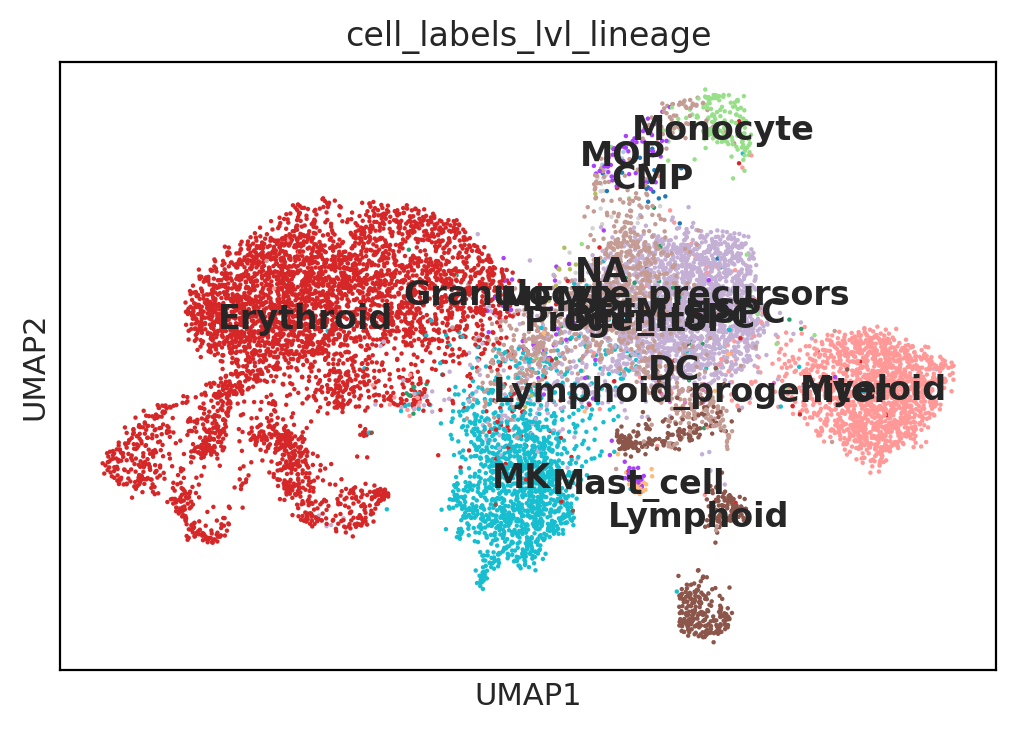

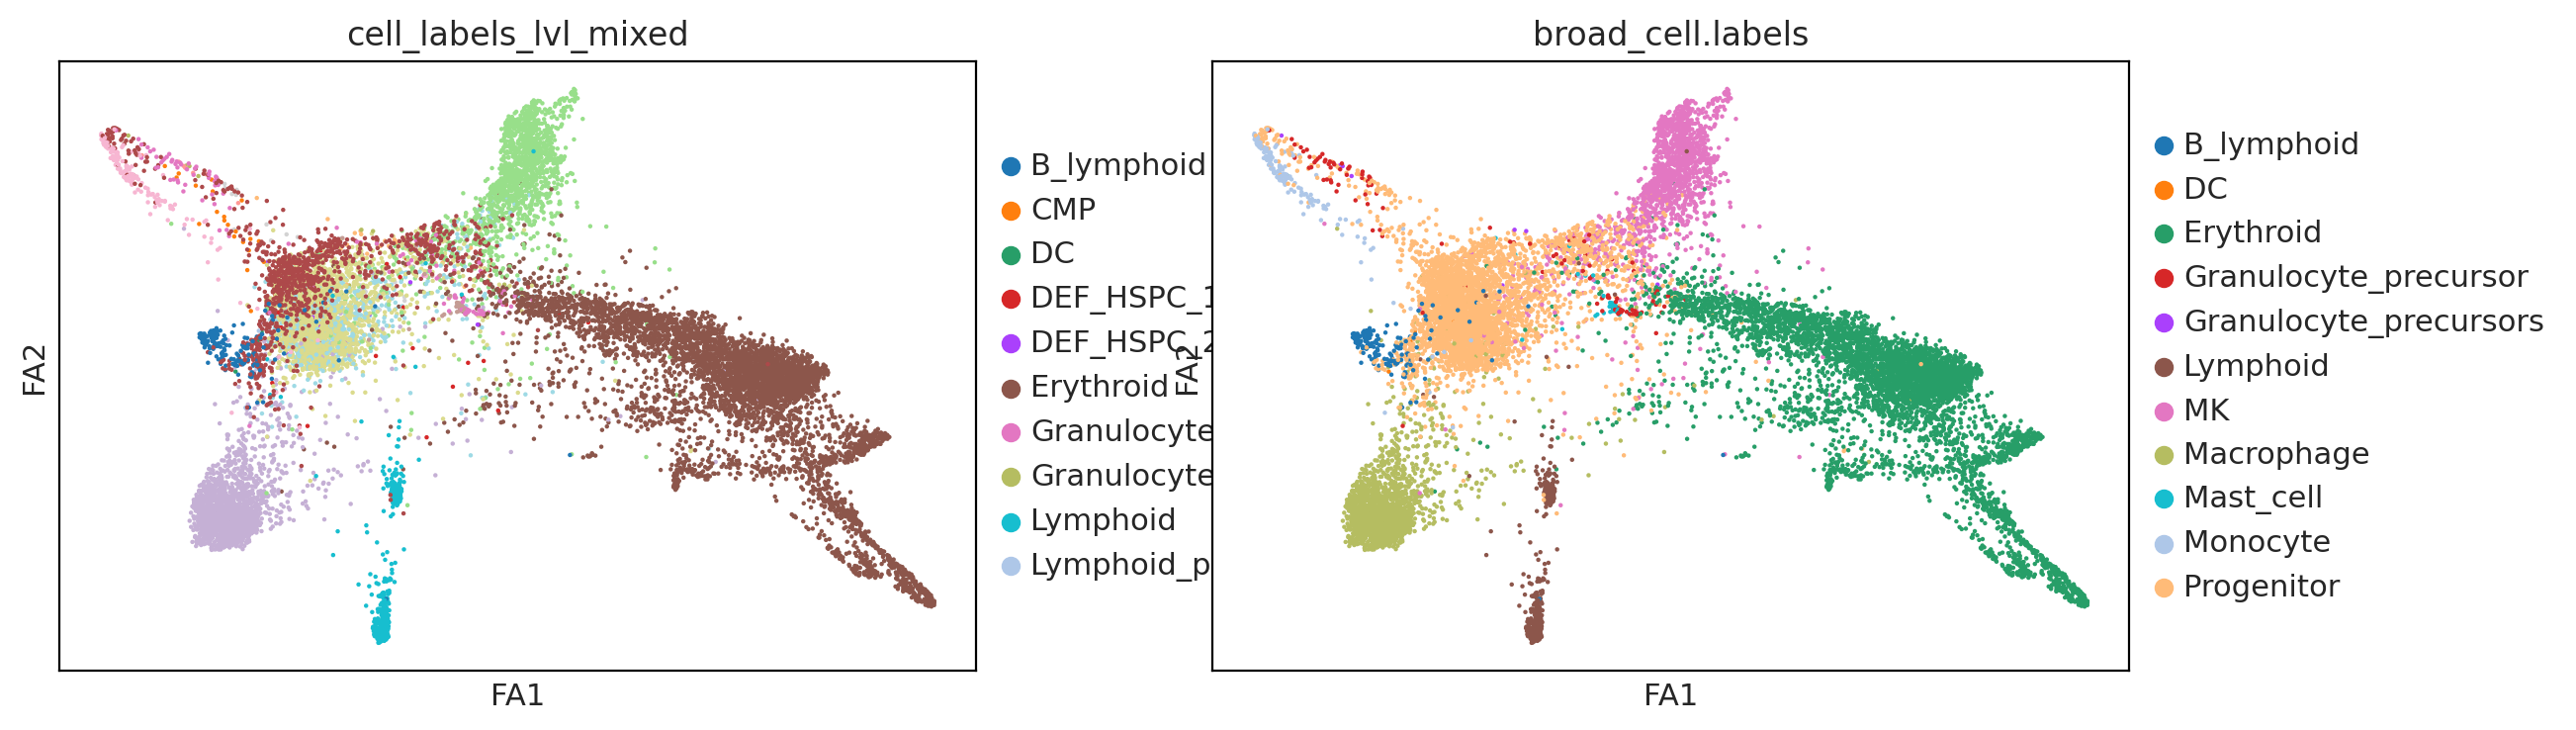

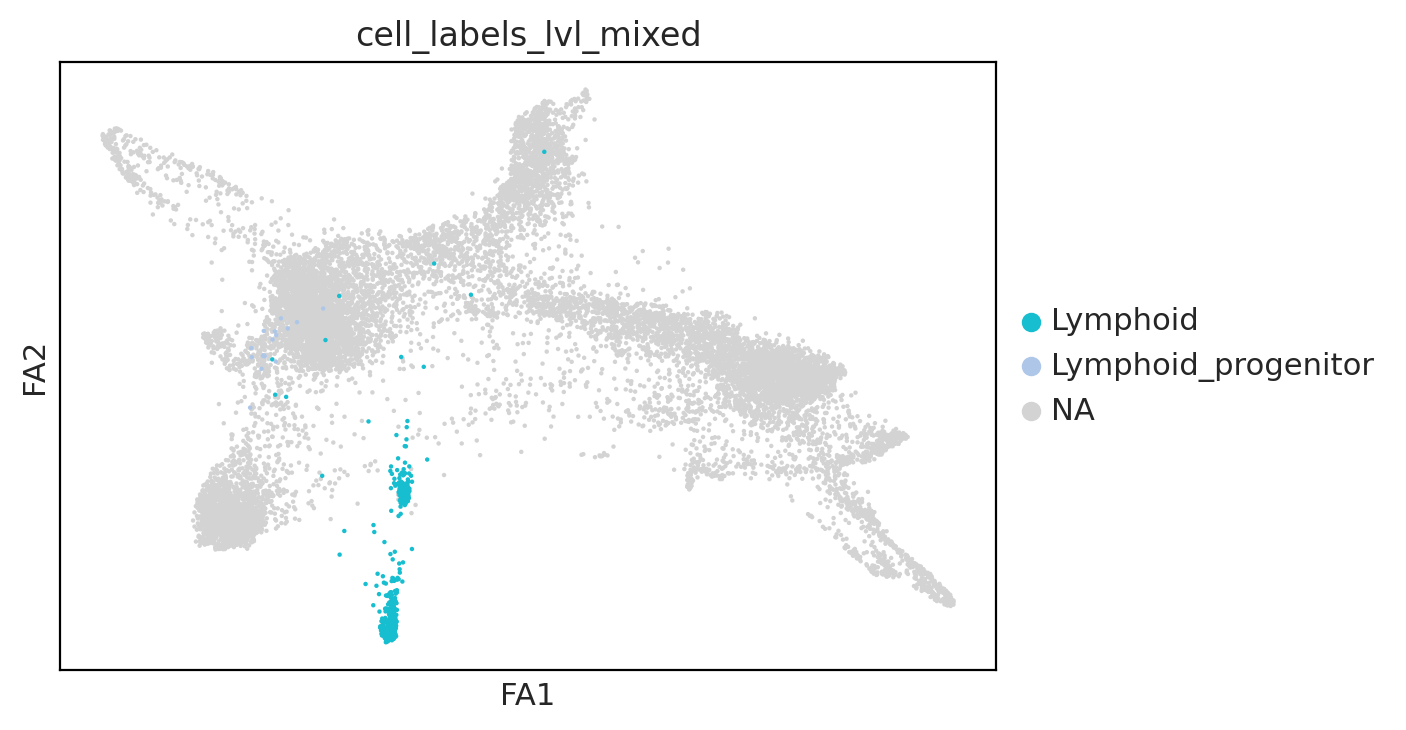

In [323]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=15,use_rep = 'X_scvi',copy=False)
sc.tl.umap(adata)
sc.tl.draw_graph(adata, layout='fa')
# # sc.tl.leiden(adata, resolution=1)
sc.pl.umap(adata,color = 'cell_labels_lvl_lineage',legend_loc = 'on data')
sc.pl.draw_graph(adata,color= ['cell_labels_lvl_mixed','broad_cell.labels'])
sc.pl.draw_graph(adata,color= 'cell_labels_lvl_mixed',groups = ['Lymphoid','Lymphoid_progenitor'])

In [324]:
adata.write('./' + stage + 'test_subsample_haem_ys_EL.h5ad')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [325]:
# # Slice to only contain age group
# stage = 'CS10_11'
# keep = list(adata.obs.index[adata.obs['stage_groups'].isin([stage])])
# keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid'])]))
# adata = adata[adata.obs.index.isin(keep)]

In [326]:
# rm = ['13']
# rm_list = adata.obs[adata.obs['leiden'].isin(['13'])]
# rm_list.to_csv('./rm_list.csv')
# rm_list = list(pd.read_csv('./rm_list.csv',index_col = 0).index)
# adata = adata[~adata.obs.index.isin(rm_list)]

In [327]:
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20,use_rep = 'X_scvi',copy=False)
# sc.tl.umap(adata)
# # sc.tl.draw_graph(adata, layout='fa')
# sc.pl.umap(adata,color = 'cell_labels_lvl_mixed')
# # sc.pl.draw_graph(adata,color= 'cell_labels_lvl_mixed')

In [328]:
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge',
       'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA',
       'percent.mito', 'organ', 'donor', 'new_data_handle', 'batch', 'HDBR_ID',
       'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num',
       'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'restricted_leiden_scvi_res15', 'umap_density_clus_prediction',
       'umap_density_clus_prediction_AEC', 'cell.labels_v2_num',
       'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval',
       'scr_doublet_call_default', 'scrublet_leiden_R', 'cell.labels_150522',
       'cell.labels_170522', 'cell.labels_170522_v2',
       'legacy_broad_cell.labels_20220519', 'V5_indexes', 'barcodes',
    

adata[adata.obs['stage_groups'].isin([stage])]# Pre-AGM only

In [329]:
# # Slice to only contain age group
# stage = 'CS10_11'
# keep = list(adata.obs.index[adata.obs['stage_groups'].isin([stage])])
# keep.append(list(adata.obs.index[adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid'])]))
# adata = adata[adata.obs.index.isin(keep)]

This detected 5000 highly variable genes. 
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `5000` genes. Consider using more than `10000` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)
Computing transition matrix based on `ct_pseudotime`



    Finish (0:00:06)
Projecting transition matrix onto `draw_graph_fa`
Adding `adata.obsm['T_fwd_draw_graph_fa']`
    Finish (0:00:03)


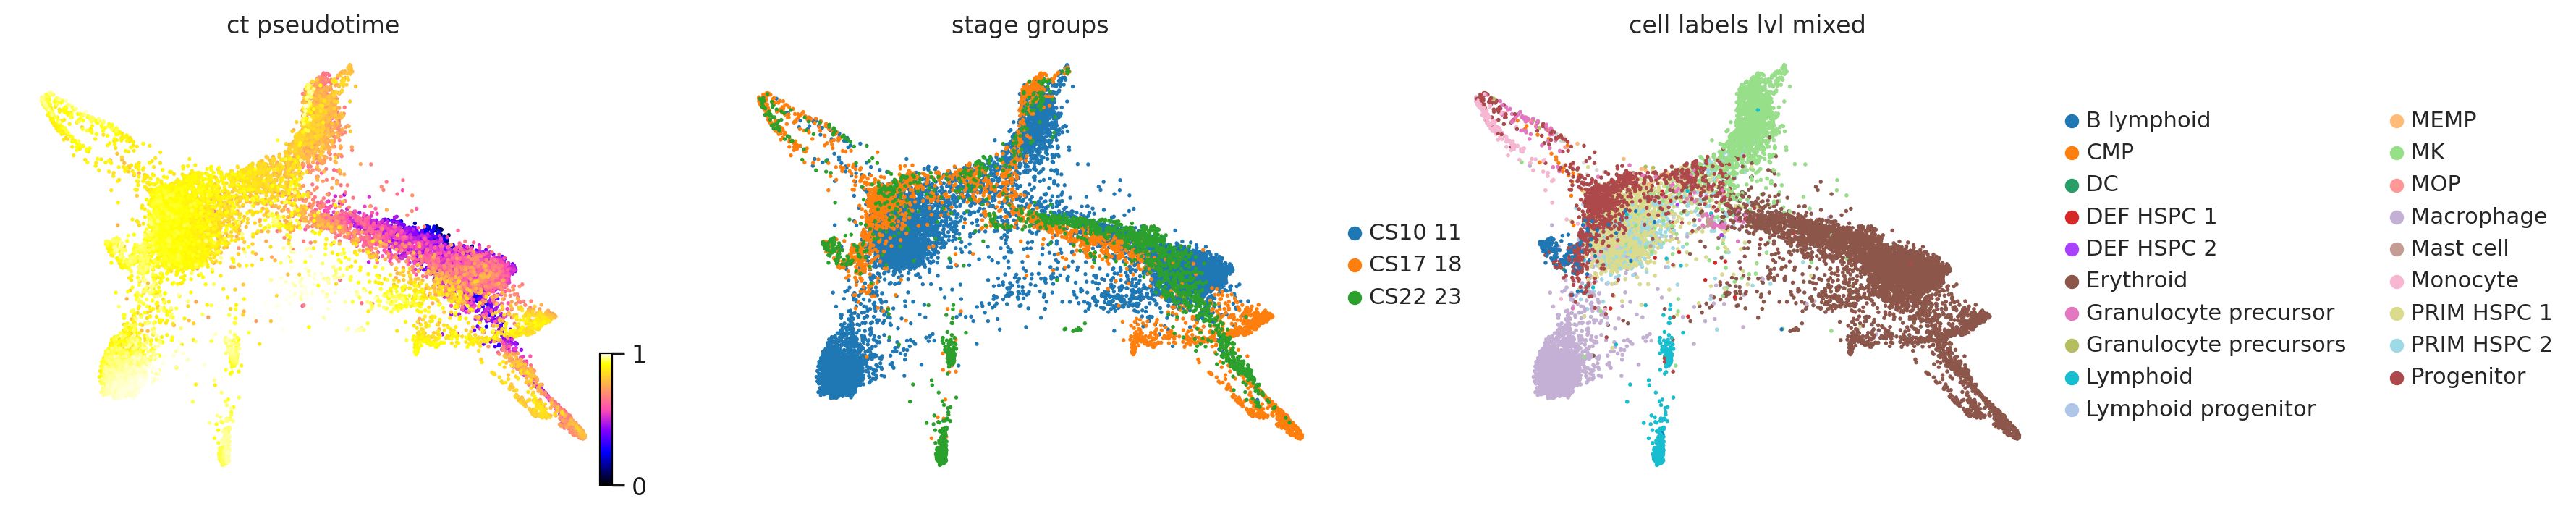

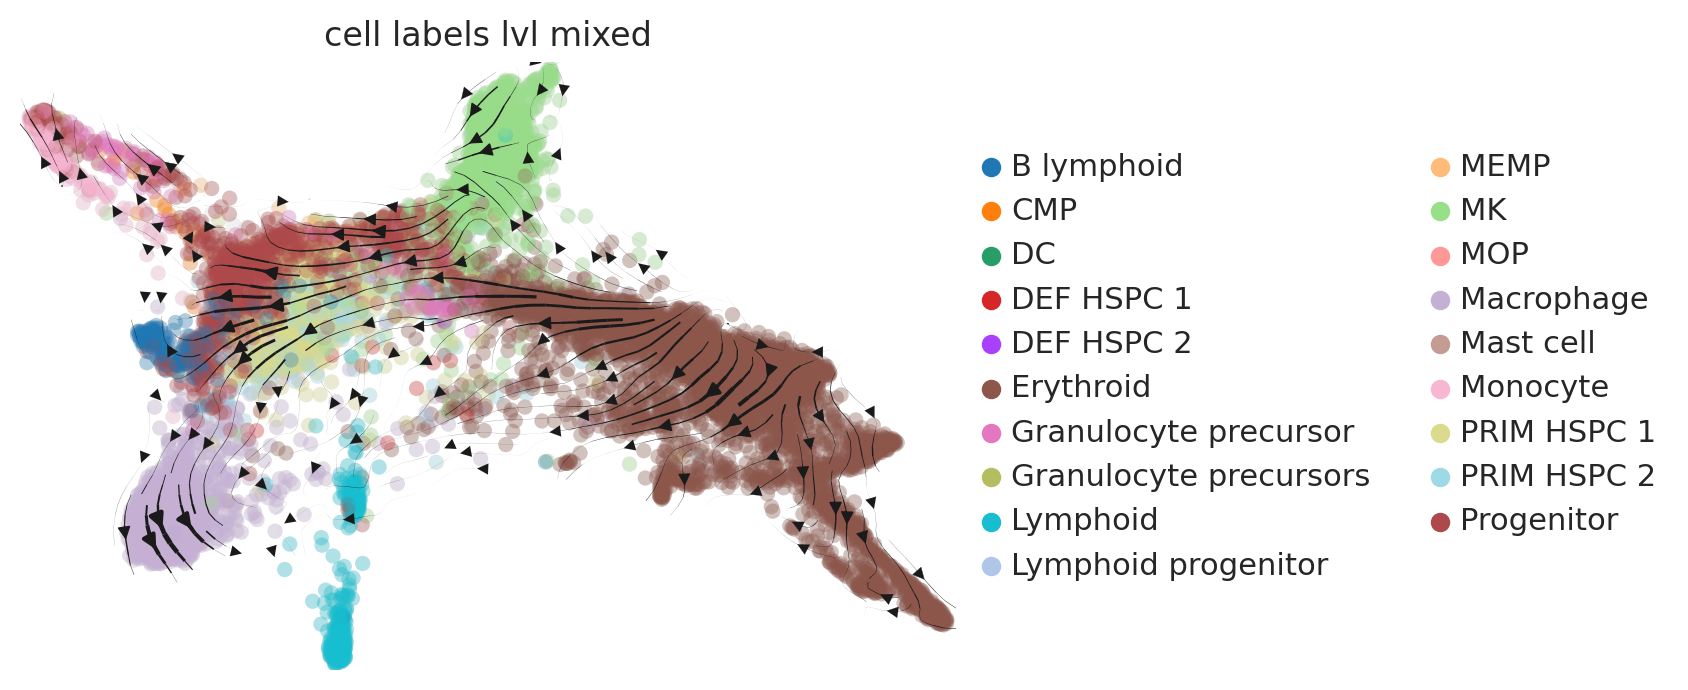

In [330]:
adata.var['highly_variable']=True

print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")
# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=20, n_neighbors=20,use_rep='X_scvi')

##########################################################################

from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel(adata)
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
ctk.compute_projection(basis="draw_graph_fa")

scv.pl.scatter(
adata,
c=["ct_pseudotime", "stage_groups","cell_labels_lvl_mixed"],
basis="draw_graph_fa",
legend_loc="right",
color_map="gnuplot2"
)
scv.pl.velocity_embedding_stream(
adata, color="cell_labels_lvl_mixed", vkey="T_fwd", basis="draw_graph_fa", legend_loc="right"
)

In [331]:
# sc.tl.paga(adata, groups='cell_labels_lvl_mixed', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)
# sc.pl.paga(adata)
# sc.tl.draw_graph(adata, layout='fa',init_pos='paga')
# sc.pl.draw_graph(adata,color= 'cell_labels_lvl_mixed')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GPCCA[n=11749, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]
Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000004e+00 -4.4487894752573941e-04 -7.0580883070250498e-04 -4.0122012987457737e-03 -1.9061001748287675e-03 -4.4856483287618922e-04 -1.6584681062032976e-03 -1.3841332984721051e-02 1.5820090644591642e-03 -4.1598705726747240e-03 -1.3165251774810332e-02 -8.5551737914362214e-03 5.5645286311429183e-03 -8.9102968695980757e-03 -5.1224955424051255e-03 
0.0000000000000000e+00 9.9610257247017642e-01 6.1288207925223602e-05 3.8291321445034314e-04 1.2475307329538830e-04 1.3379302920169108e-04 3.9270975926700824e-04 1.2726345029291295e-03 2.4039933979690925e-04 5.9758309941138630e-04 1.7936051967892468e-03 2.9762704297639636e-05 -5.4201046911123271e-04 9.9926407761518265e-04 1.0985863528538997e-03 
0.0000000000000000e+00 0.0000000000000000e+00 9.9583689575379641e-01 -7.2381495938712891e-04 3.6897367023591910e-04 5.9918136330845218e-0

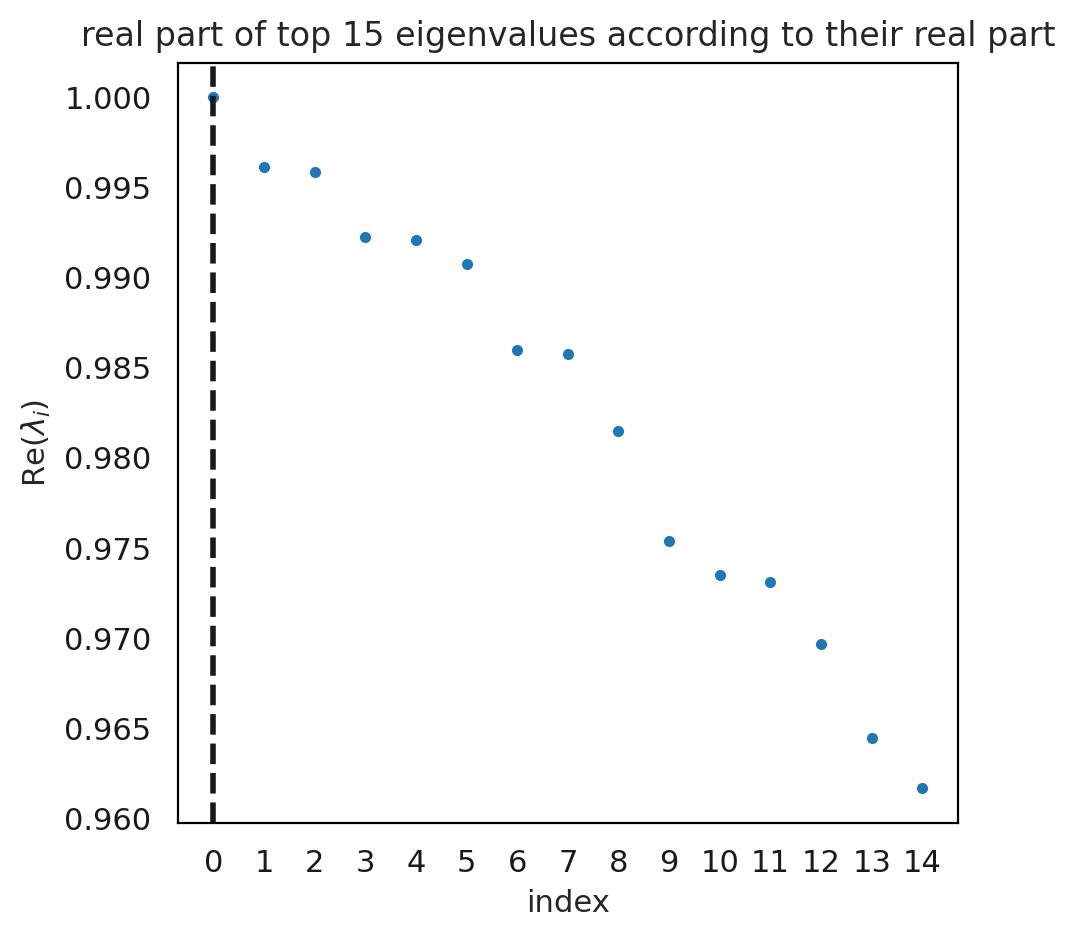

In [332]:
from cellrank.tl.estimators import GPCCA
g_fwd = GPCCA(ctk)
print(g_fwd)
g_fwd.compute_schur(n_components=15, method= 'krylov') #method='brandts is true schur distribution but will not scale
g_fwd.plot_spectrum(real_only=True)

In [333]:
list(adata.obs['cell_labels_lvl_lineage'].unique())

['PRIM_HSPC',
 'Erythroid',
 'Myeloid',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC',
 'Monocyte',
 'MEMP',
 nan,
 'DC',
 'Granulocyte_precursors',
 'MOP',
 'Lymphoid',
 'CMP',
 'Progenitor']

In [334]:
adata.obs.groupby(['cell_labels_lvl3']).apply(len)

cell_labels_lvl3
CMP                         22
DEF_HSPC_1                  41
DEF_HSPC_2                  15
Early_Erythroid            421
Eo_Baso_Mast_precursor       5
Erythroid                 1996
Lymphoid B lin               2
Lymphoid_progenitor         16
MEMP                        26
MK                        1101
MOP                          8
Macrophage                1494
Mast_cell                    4
Mid_Erythroid                1
Mono Mac pre DC2             1
Monocyte_0                   3
Monocyte_ys_1                3
NK                           1
Neutrophil_precursor         4
PRIM_HSPC_1               1800
PRIM_HSPC_2                498
Pre DC2                      4
Pre_Macrophage               2
Promonocyte                  7
dtype: int64

In [335]:
list(adata.obs['cell_labels_lvl3'].unique())

['PRIM_HSPC_1',
 'Erythroid',
 'Early_Erythroid',
 'Macrophage',
 'PRIM_HSPC_2',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC_2',
 'Monocyte_0',
 'Promonocyte',
 'MEMP',
 'DEF_HSPC_1',
 nan,
 'Pre DC2',
 'Mono Mac pre DC2',
 'Eo_Baso_Mast_precursor',
 'Monocyte_ys_1',
 'MOP',
 'Neutrophil_precursor',
 'Lymphoid B lin',
 'NK',
 'CMP',
 'Pre_Macrophage',
 'Mid_Erythroid']

In [336]:
list(adata.obs['cell_labels_lvl_lineage'].unique())

['PRIM_HSPC',
 'Erythroid',
 'Myeloid',
 'MK',
 'Lymphoid_progenitor',
 'Mast_cell',
 'DEF_HSPC',
 'Monocyte',
 'MEMP',
 nan,
 'DC',
 'Granulocyte_precursors',
 'MOP',
 'Lymphoid',
 'CMP',
 'Progenitor']

In [337]:
adata.obs.groupby(['cell_labels_lvl_lineage','tissue']).apply(len)

cell_labels_lvl_lineage  tissue
CMP                      YS          22
DC                       YS           5
DEF_HSPC                 YS          56
Erythroid                Liver     2163
                         YS        2418
Granulocyte_precursors   Liver      117
                         YS           9
Lymphoid                 Liver      486
                         YS           3
Lymphoid_progenitor      YS          16
MEMP                     YS          26
MK                       Liver      307
                         YS        1101
MOP                      YS           8
Mast_cell                Liver       38
                         YS           4
Monocyte                 Liver      150
                         YS          13
Myeloid                  YS        1496
PRIM_HSPC                YS        2298
Progenitor               Liver      976
dtype: int64

# Manually set macrostates

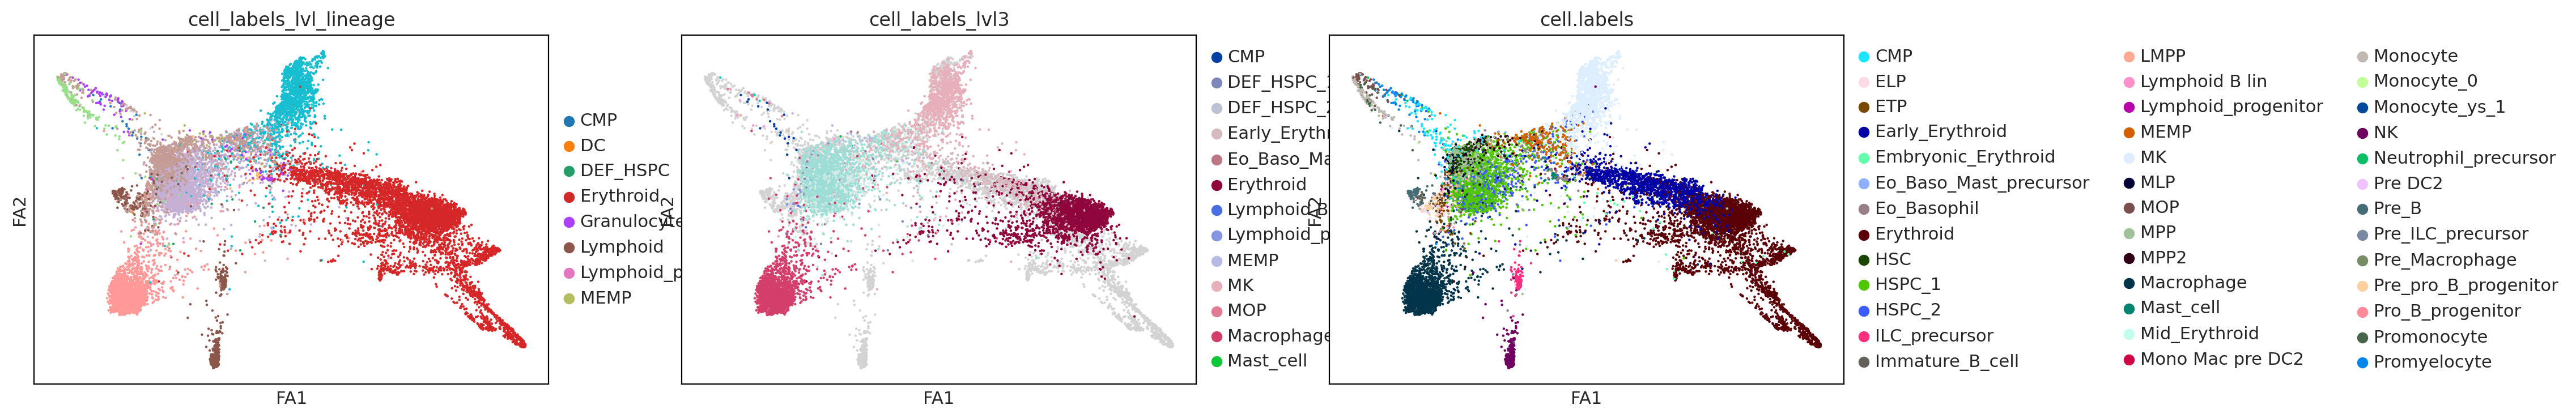

In [338]:
sc.pl.draw_graph(adata,color =['cell_labels_lvl_lineage','cell_labels_lvl3','cell.labels'] )

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


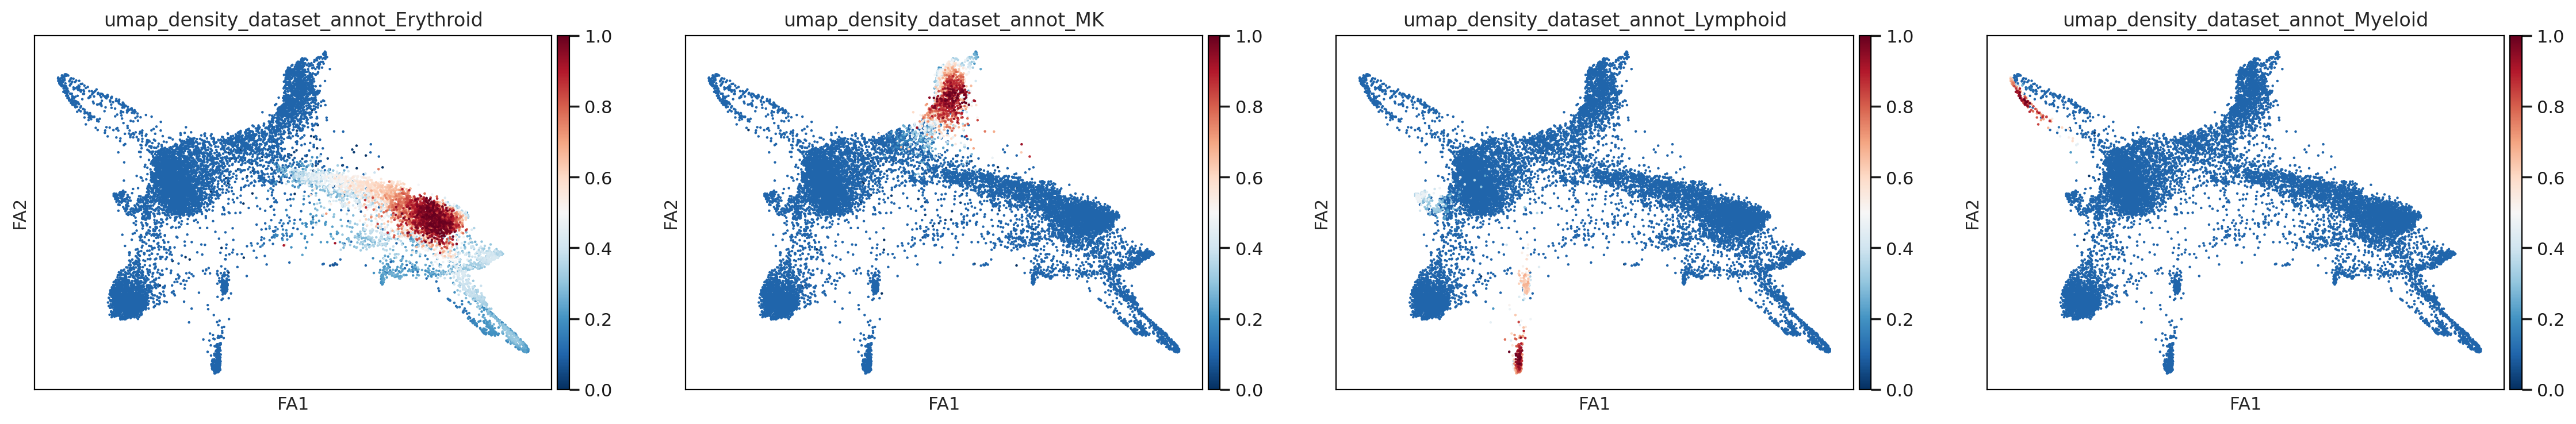

In [547]:
var_group = 'cell_labels_lvl_lineage'
sc.tl.embedding_density(adata, basis='umap', groupby=var_group, key_added='umap_density_dataset_annot', components=None)
macro = {}
state_init = [
'Erythroid',    
'MK',
#'Monocyte',
# 'Macrophage',
# 'Mast_cell',
 'Lymphoid',
#'PRIM_HSPC',
'Myeloid',
]
densities = []
for i in state_init:
    # find KDE center of density for each state
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs[var_group].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    macro[i] =adata.obs.index[adata.obs.index.isin(adata.obs['umap_density_dataset_annot_'+i].nlargest(30).index)]
    densities.append('umap_density_dataset_annot_'+i)
    #macro[i] = adata[adata.obs["cell_labels_lvl_lineage"] == i].obs_names
g_fwd.set_terminal_states(macro)
sc.pl.draw_graph(adata,color = densities)

In [531]:
# list(g_fwd.macrostates.unique())

In [548]:
adata.obsm

AxisArrays with keys: X_scvi, X_umap, _scvi_extra_categorical_covs, X_draw_graph_fa, T_fwd_draw_graph_fa, schur_vectors_fwd

In [549]:
# cr.pl.terminal_states(adata, discrete=True)

In [550]:
# g_fwd.plot_macrostates(discrete=True, legend_loc="right", size=100, basis="draw_graph_fa")

In [551]:
#g_fwd.compute_macrostates(n_states=10, cluster_key="cell_labels_lvl_lineage")#"cell_labels_lvl_lineage"
#g_fwd.plot_macrostates(discrete=True, legend_loc="right", size=100, basis="umap")
# define terminal states as state_init with max num
# state_init = [
# 'Erythroid',    
# 'MK',
#  'Macrophage',
#  'Mast_cell',
# #'Granulocyte',
#  'Lymphoid',]
# states = []
# for i in state_init:
#     state_multi = sorted(g_fwd.macrostates[g_fwd.macrostates.str.contains(i, na=False)].unique())[-1]
#     states.append(state_multi)
# g_fwd.set_terminal_states_from_macrostates(names=states)
# states

In [552]:
adata_orig = adata.copy()

In [553]:
adata = adata_orig.copy()

In [554]:
g_fwd_orig = g_fwd.copy()
adata_pre_split = adata.copy()

In [555]:
# g_fwd = g_fwd_orig.copy()
#adata = adata_pre_split.copy()

In [556]:
map_state = ['PRIM_HSPC','DEF_HSPC']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    
map_state = ['Progenitor']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='broad_cell.labels', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

### Informally, given a (finite, discrete) Markov chain with a set of transient states  and a set of absorbing states , the absorption probability for cell  from  to reach cell  from  is the probability that a random walk initialized in  ### will reach absorbing state .

### In our context, states correspond to cells, in particular, absorbing states correspond to cells in terminal states.

In [557]:
#adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

In [ ]:
# states = states_inc 
#g_fwd.compute_macrostates(n_states=10, cluster_key="cell_labels_lvl_lineage")
#g_fwd.set_terminal_states_from_macrostates(names=states)
g_fwd.compute_absorption_probabilities()#solver='direct'
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="draw_graph_fa")
adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities
cr.pl.circular_projection(adata, keys=["cell_sets", "cell_labels_lvl3"], early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC_1'},lineages = state_init,legend_loc="right", title="")
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = stage )

In [559]:
term_state_probs = g_fwd.absorption_probabilities.copy()

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [560]:
adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

In [561]:
adata.obs.groupby(['broad_cell.labels','cell_labels_lvl_mixed']).apply(len)

broad_cell.labels       cell_labels_lvl_mixed 
B_lymphoid              B_lymphoid                 158
DC                      DC                           5
Erythroid               Erythroid                 4581
Granulocyte_precursor   Granulocyte_precursor      117
Granulocyte_precursors  Granulocyte_precursors       9
Lymphoid                Lymphoid                   331
MK                      MK                        1408
Macrophage              Macrophage                1496
Mast_cell               Mast_cell                   42
Monocyte                Monocyte                   163
Progenitor              CMP                         22
                        DEF_HSPC_1                  41
                        DEF_HSPC_2                  15
                        Lymphoid_progenitor         16
                        MEMP                        26
                        MOP                          8
                        PRIM_HSPC_1               1800
                  

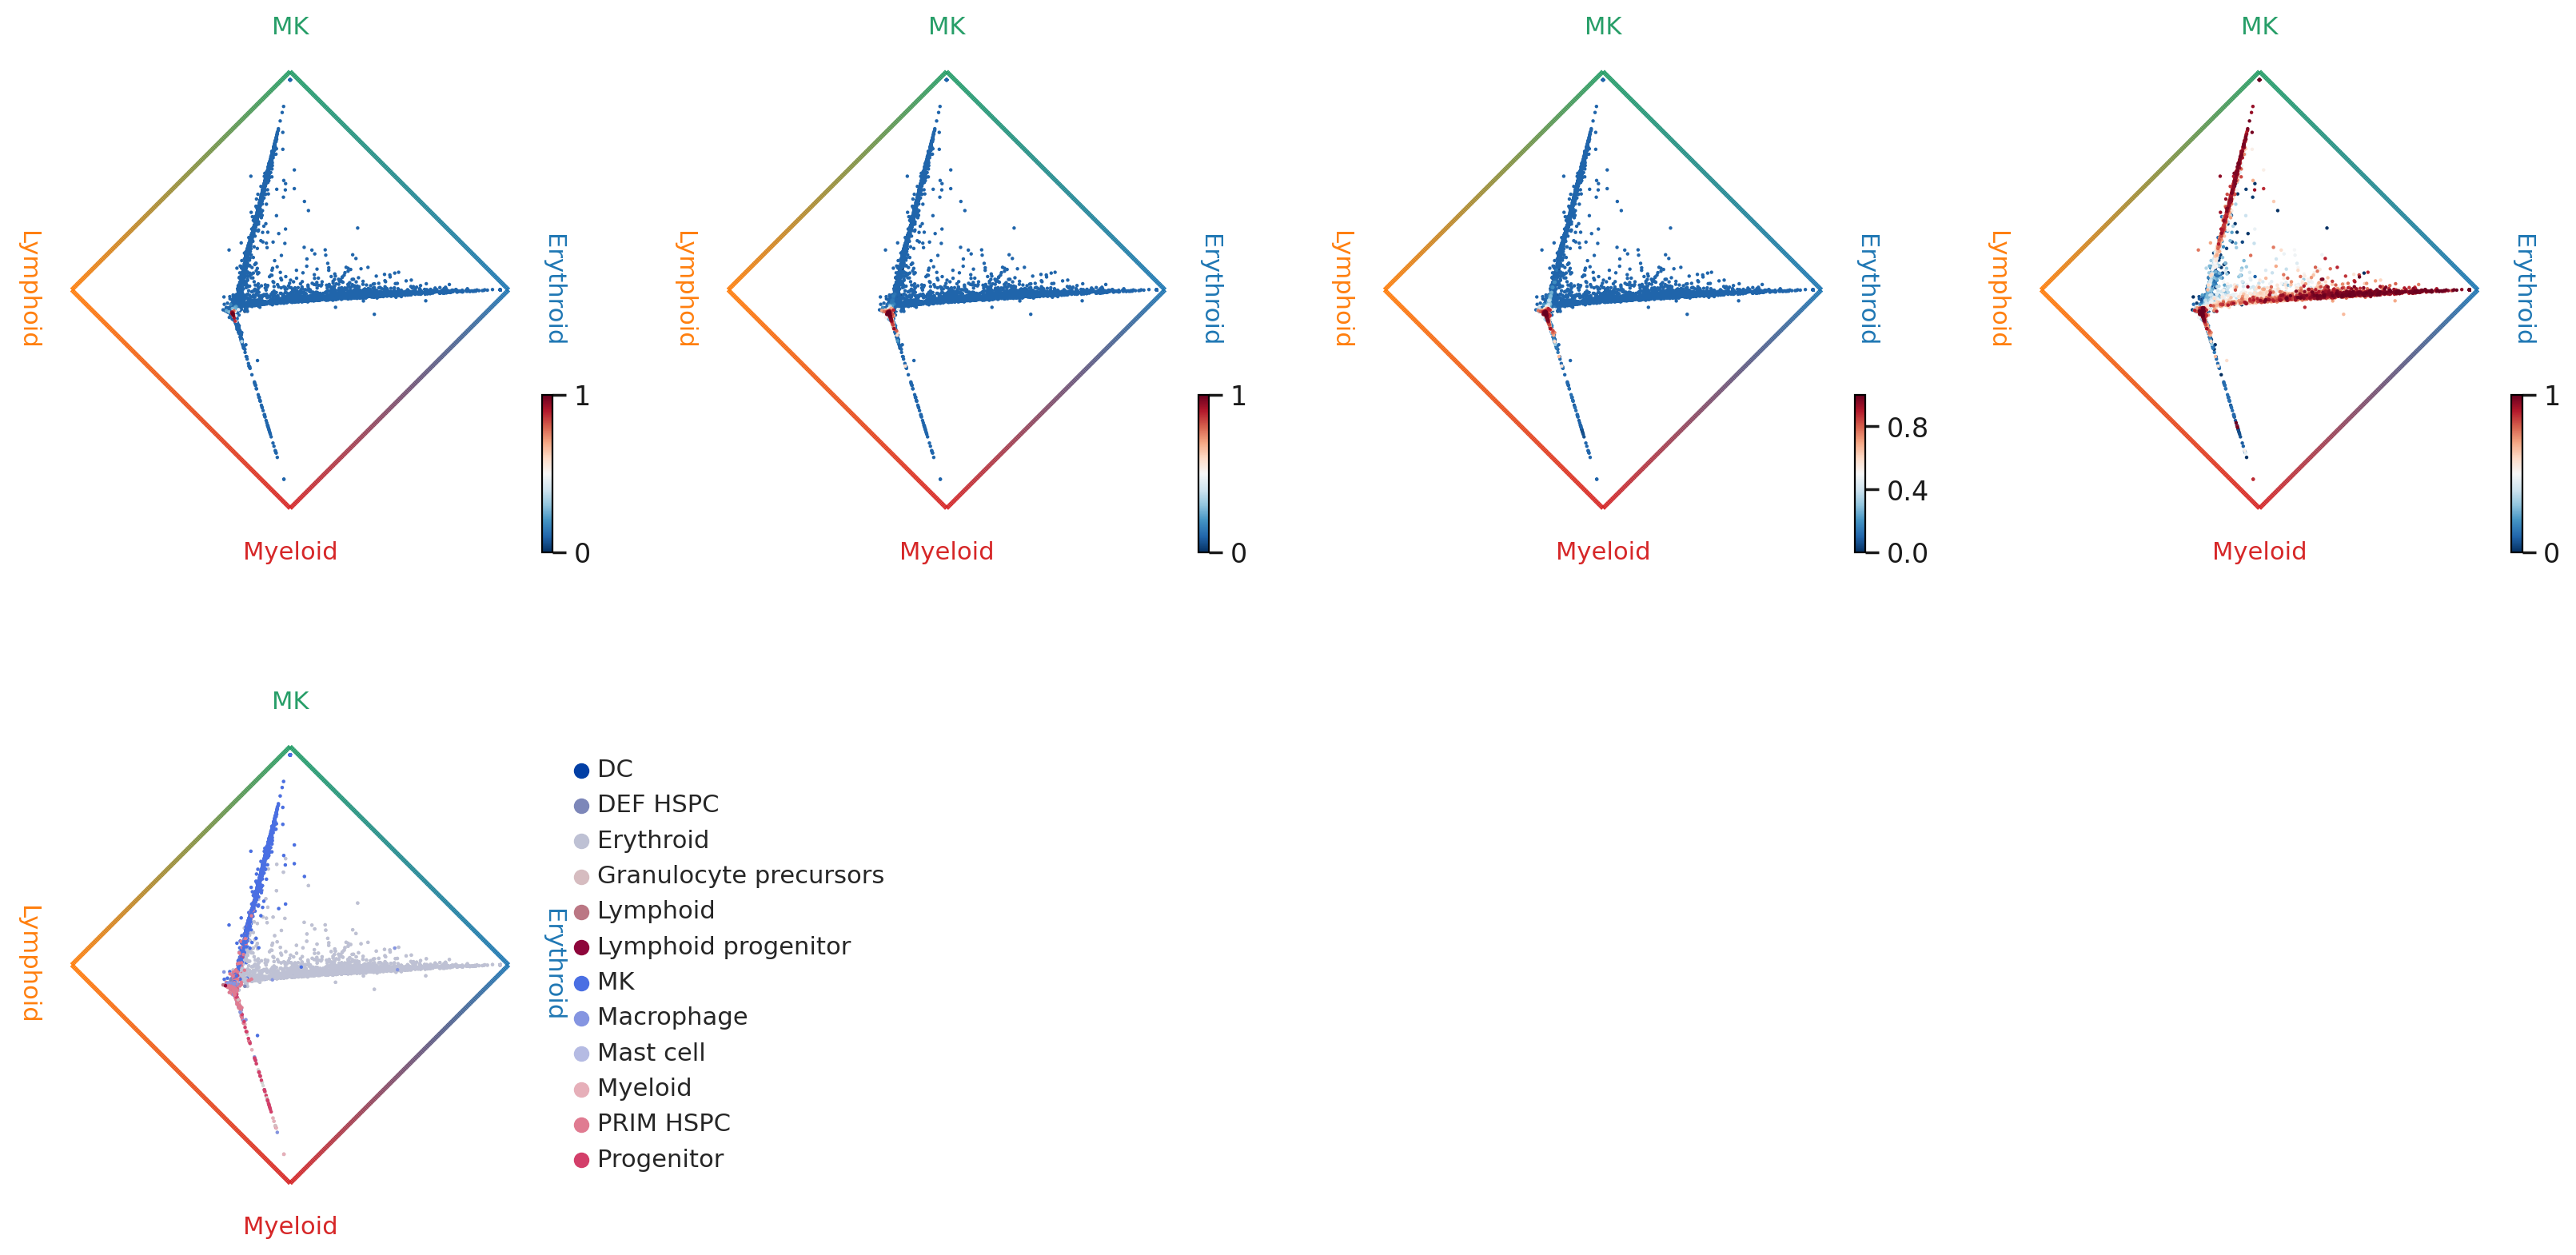

In [562]:
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_DEF_HSPC','umap_density_dataset_annot_PRIM_HSPC','umap_density_dataset_annot_Progenitor','umap_density_dataset_annot', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = stage,cmap = 'RdBu_r' ,size = 10)

In [511]:
adata.obs['stage_float'] = adata.obs['stage'].str.replace('CS','')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [512]:
adata.obs['stage_float']

Wang_et_al_AAACCTGCACTTAAGC_1-0    10
Wang_et_al_AAACCTGGTAACGACG_1-0    10
Wang_et_al_AAACCTGGTCAAAGAT_1-0    10
Wang_et_al_AAACCTGGTCCGAAGA_1-0    10
Wang_et_al_AAACCTGGTCCGCTGA_1-0    10
                                   ..
Wang_et_al_TTTGTCAAGTACCGGA_2-0    11
Wang_et_al_TTTGTCAAGTGTGAAT_2-0    11
Wang_et_al_TTTGTCACATCGGGTC_2-0    11
Wang_et_al_TTTGTCACATCGTCGG_2-0    11
Wang_et_al_TTTGTCAGTCAATGTC_2-0    11
Name: stage_float, Length: 7492, dtype: object

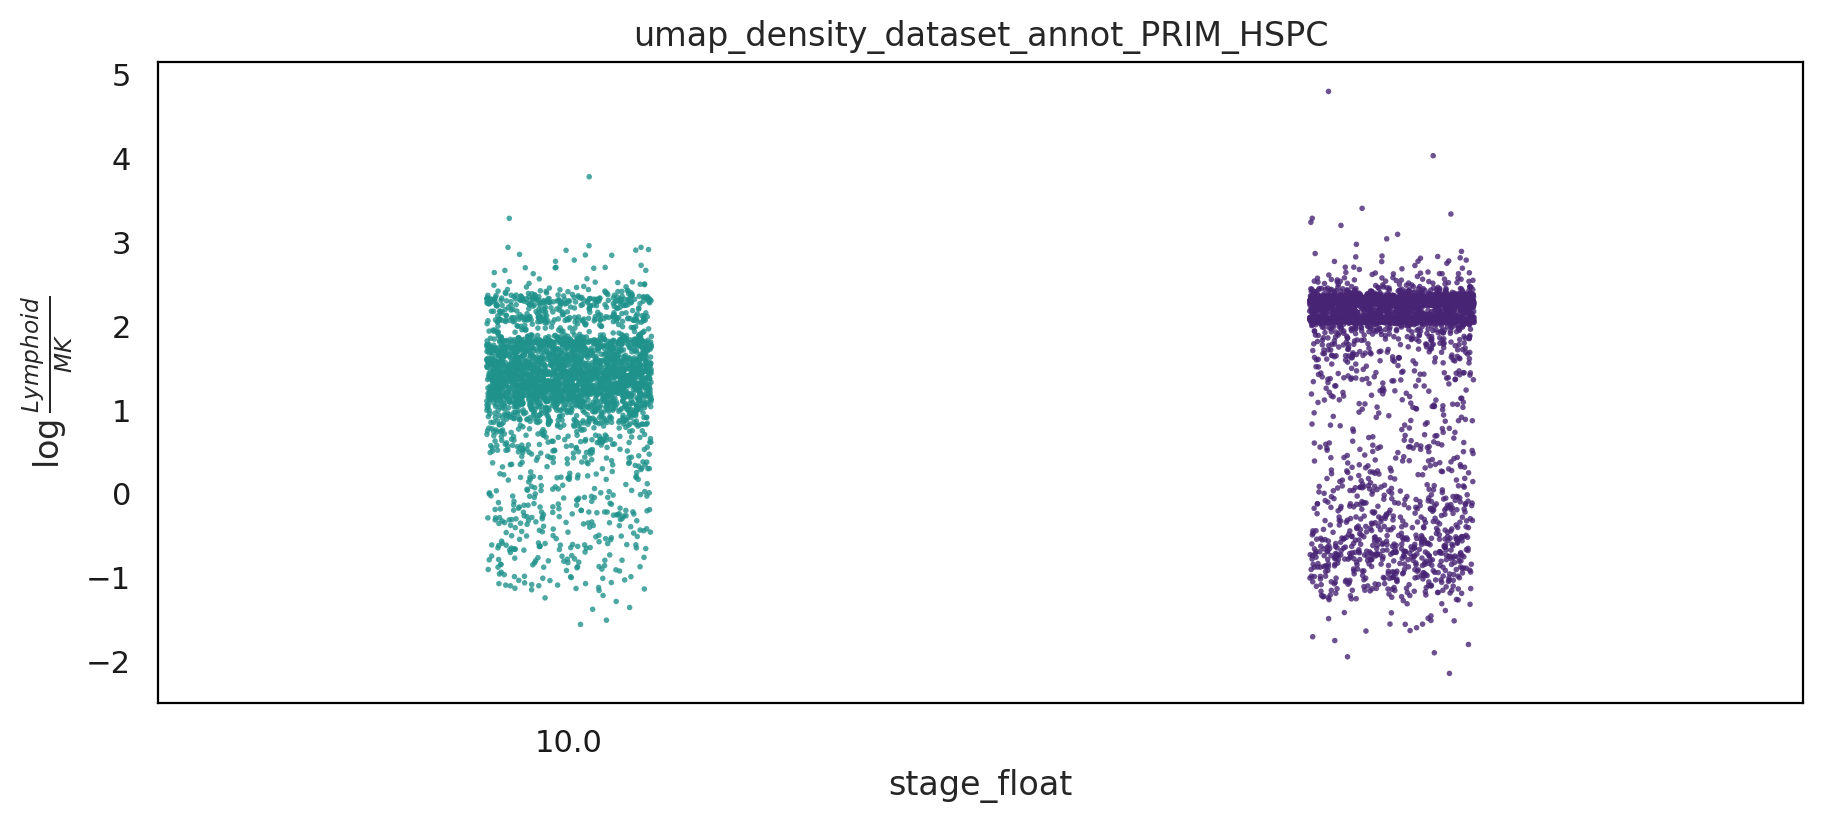

In [68]:
cr.pl.log_odds(
    adata,
    lineage_1="Lymphoid",
    lineage_2="MK",
    time_key="stage_float",
    keys=["umap_density_dataset_annot_PRIM_HSPC"],
    threshold=0,
    size=2,
    xticks_step_size=4,
    figsize=(9, 4),
    legend_loc="upper right out",
)